In [37]:
#%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans
import cv2
import os
import sys
from tqdm import tqdm_notebook as tqdm

plt.style.use("ggplot")

## K-means法による画素に関するクラスタリング

A Jupyter Widget

Start 2149fc4d...
Start 22347650...
Start 3d035224...
Start 48e2c628...
Start 721788da...
Start 793a83ad...
Start 7ea5ecd6...
Start 955a168f...
Start a18a966a...
Start b65a8036...
Start dbbc247a...


/Users/Kakutofu/.pyenv/versions/anaconda3-5.0.0/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Start fb92b4fd...



A Jupyter Widget

Start 0ff4c948...
Start 3d6abe0f...
Start 50d3825a...
Start 57c5b5bf...
Start 5b3da03d...
Start 71e6ee11...
Start 77bced4b...
Start 8745df98...
Start 90e7d5ef...
Start 92a8fa1b...
Start b29d5125...
Start b5108a38...
Start e5bb5d0c...
Start fb616c3d...



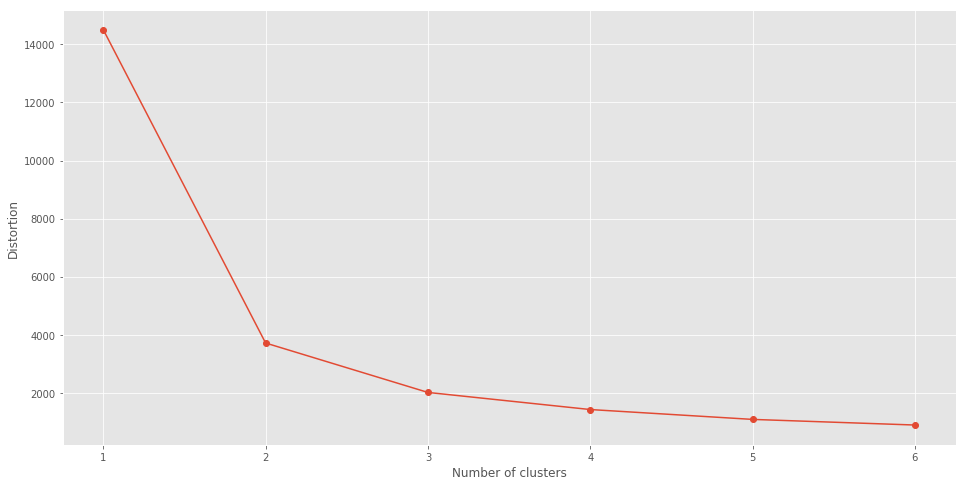

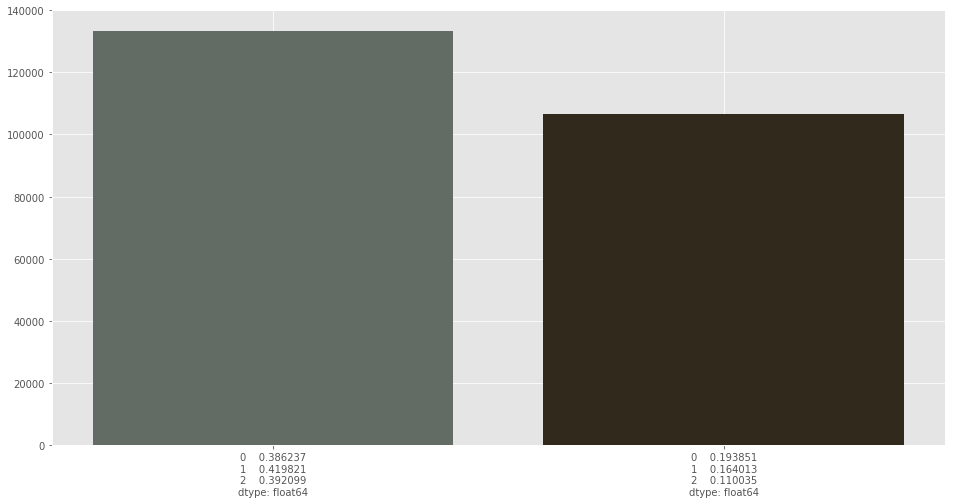

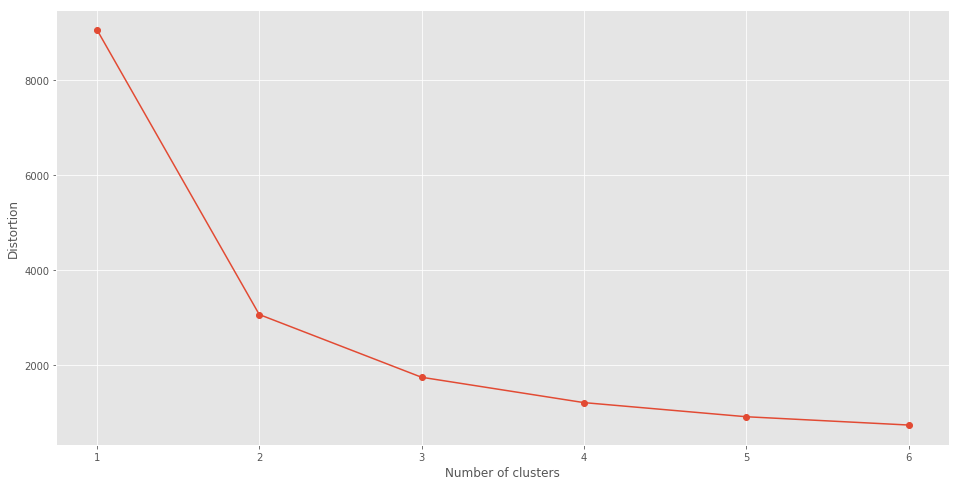

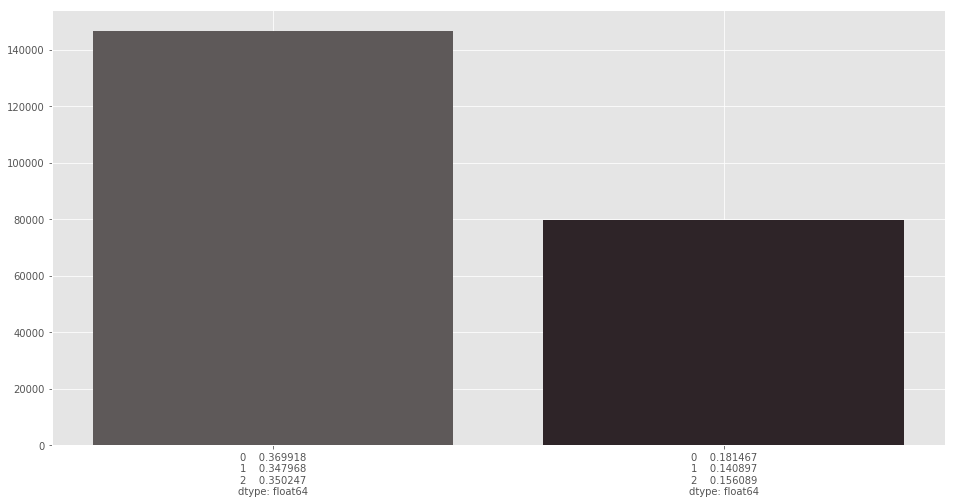

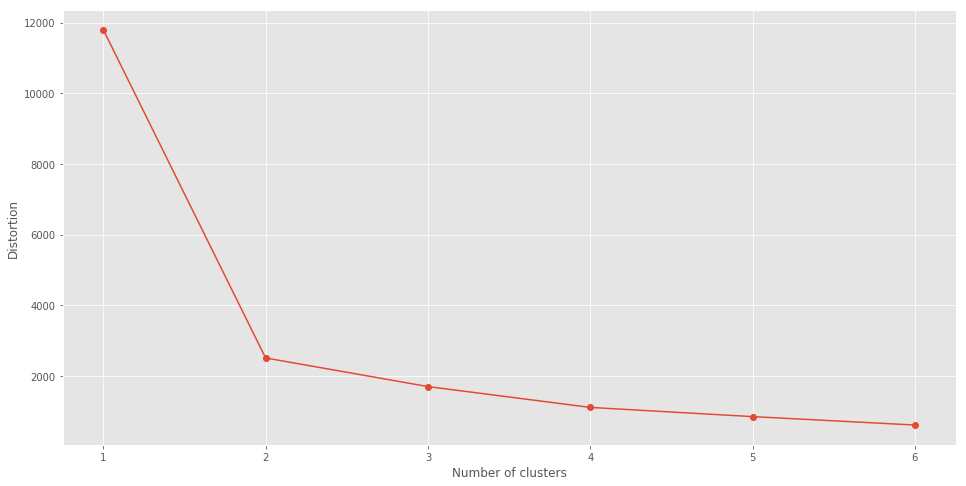

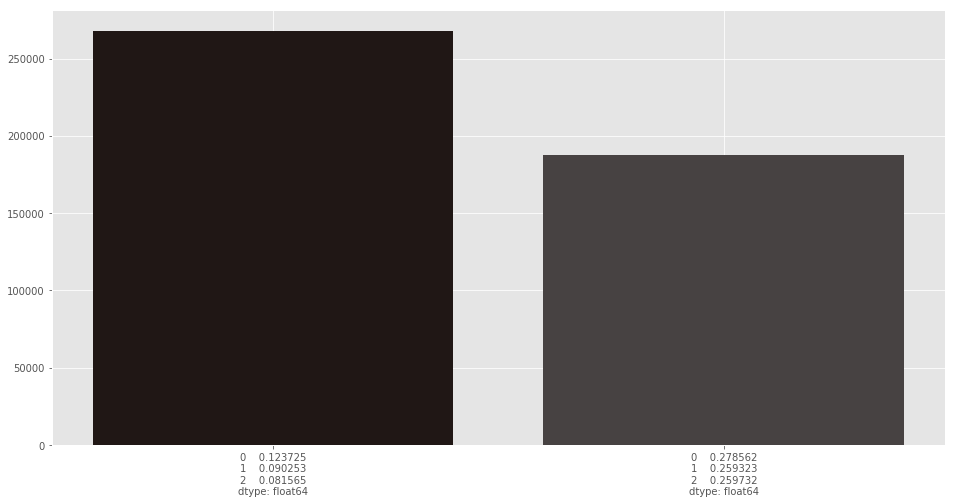

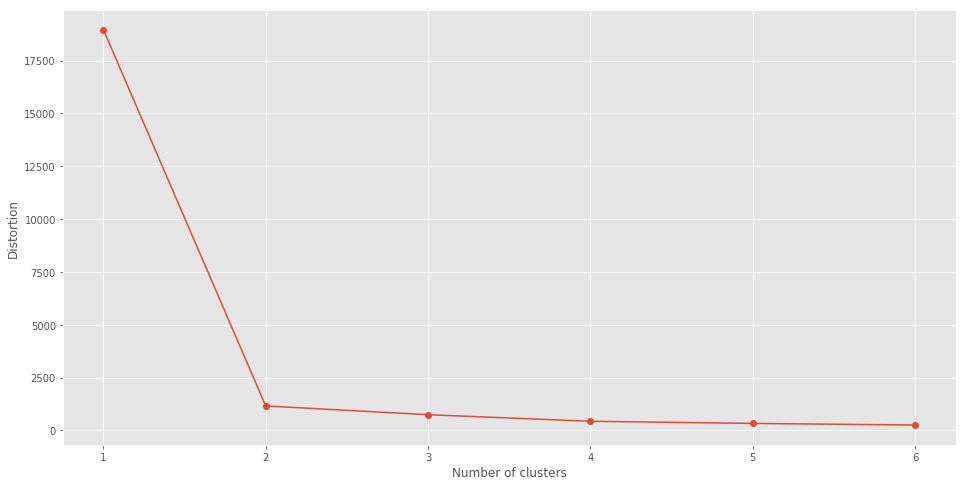

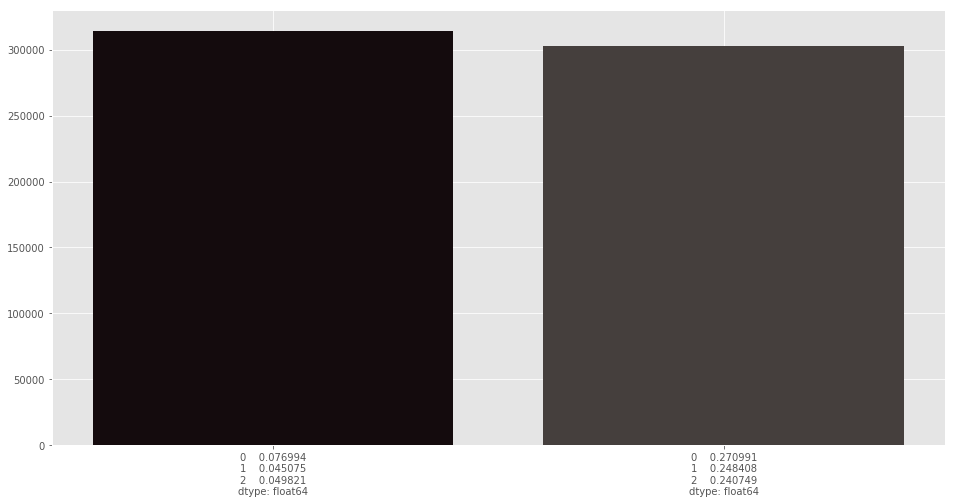

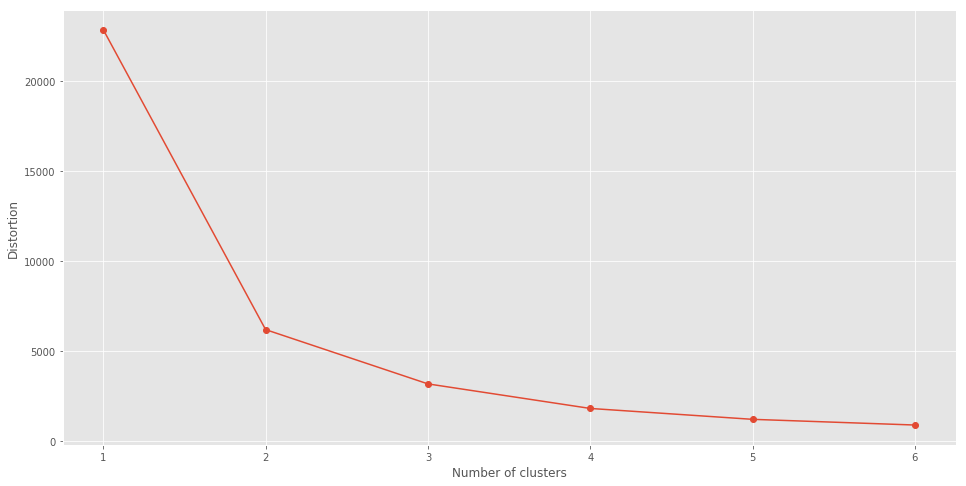

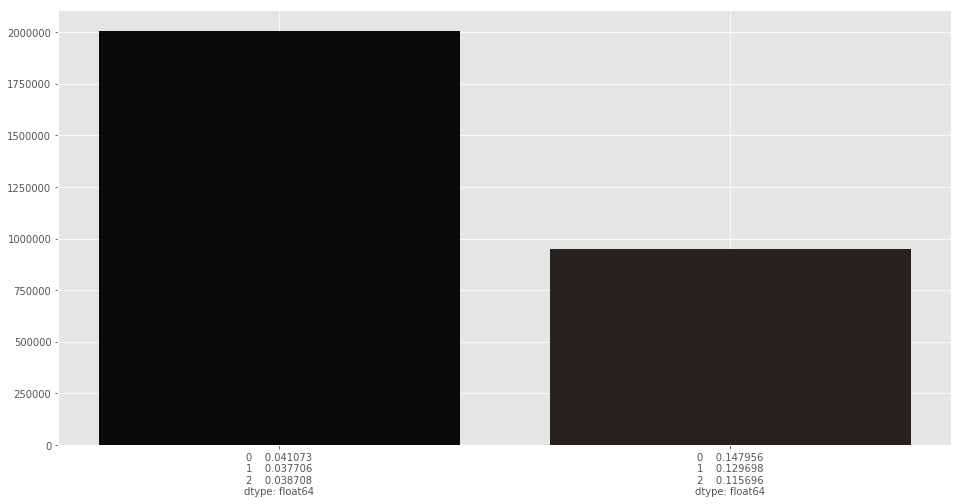

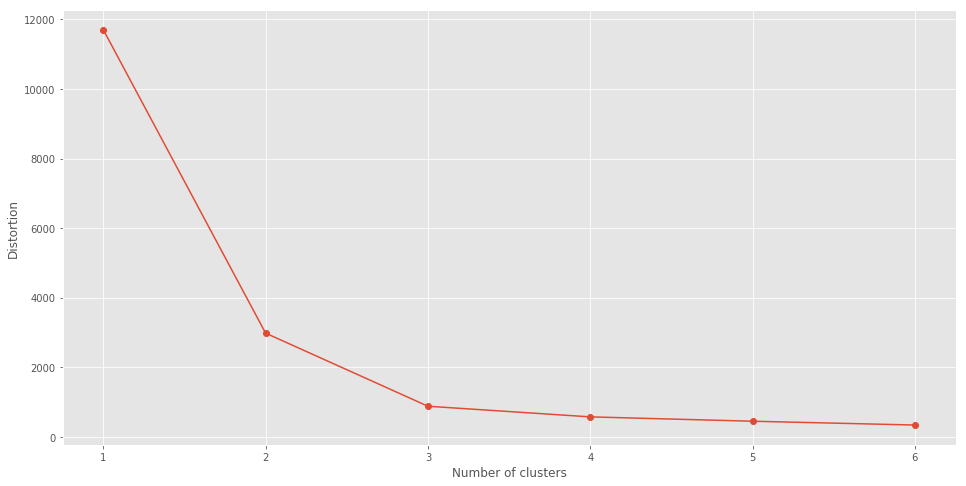

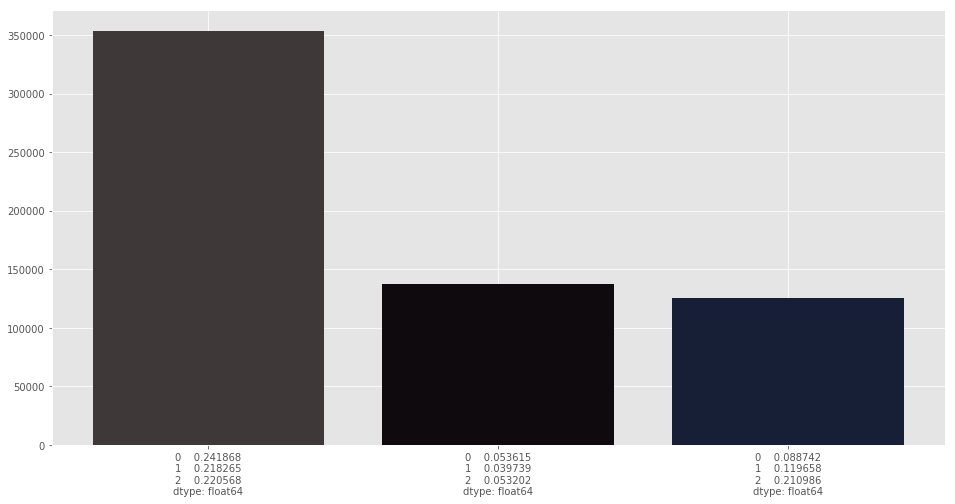

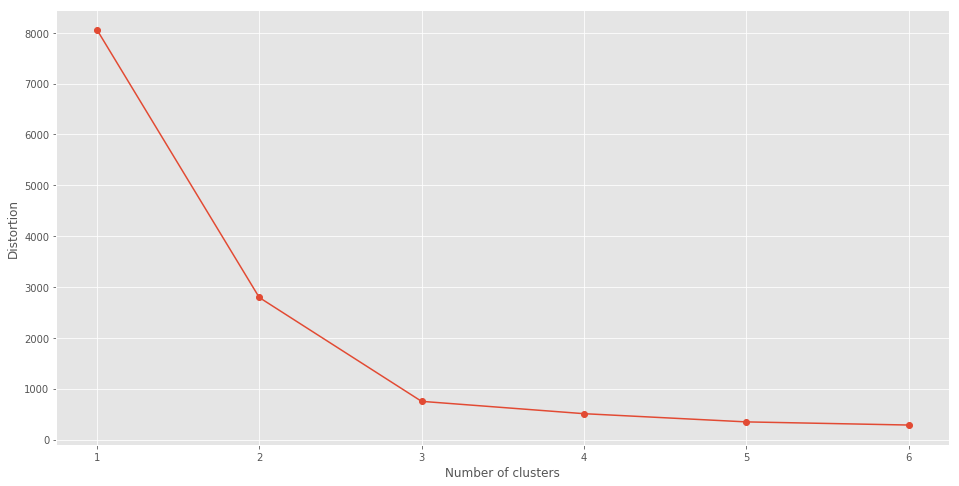

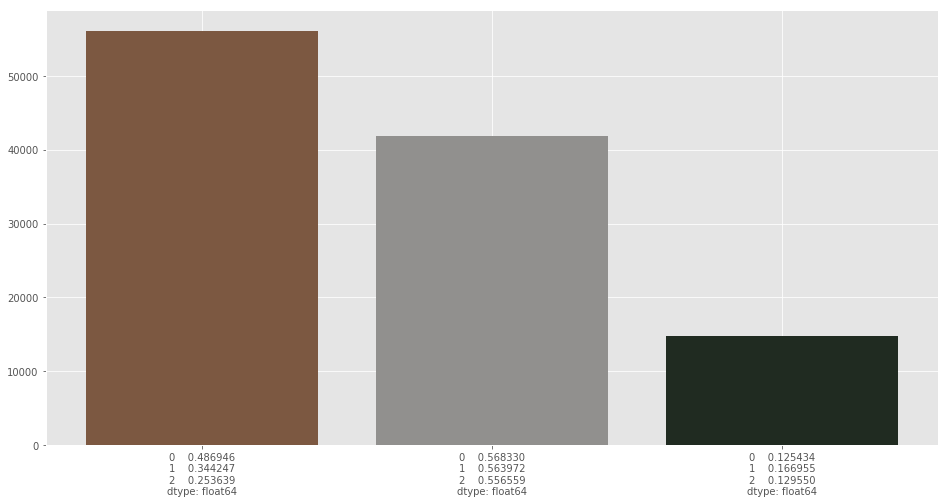

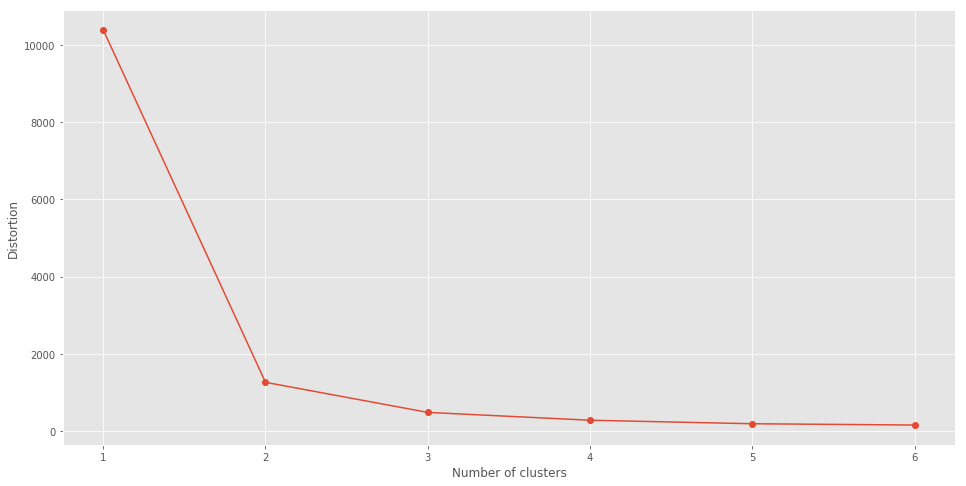

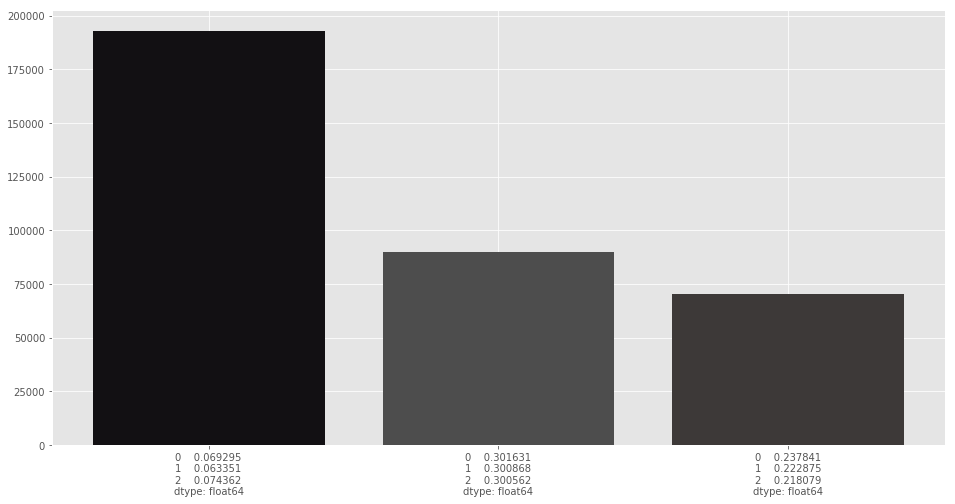

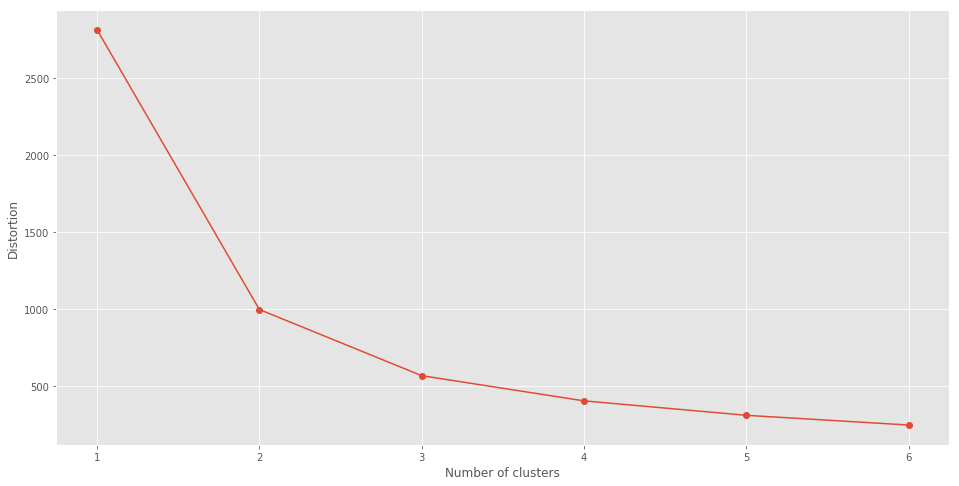

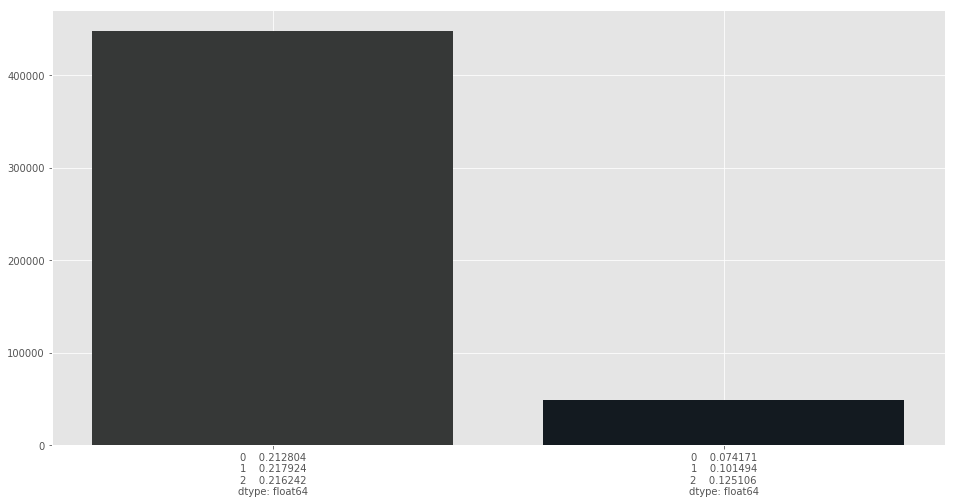

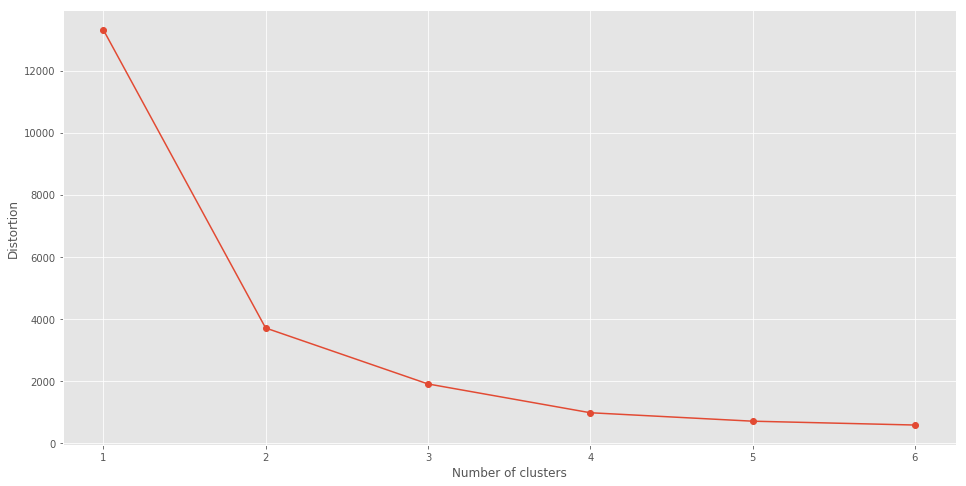

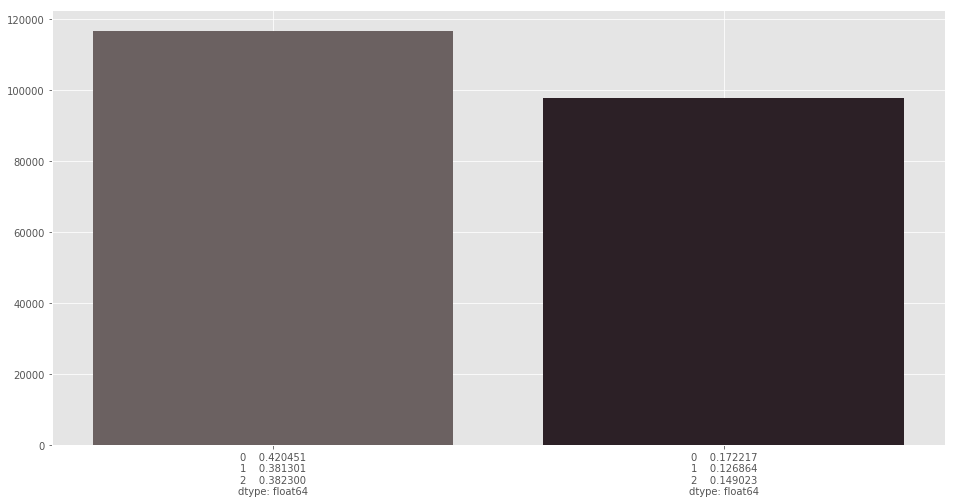

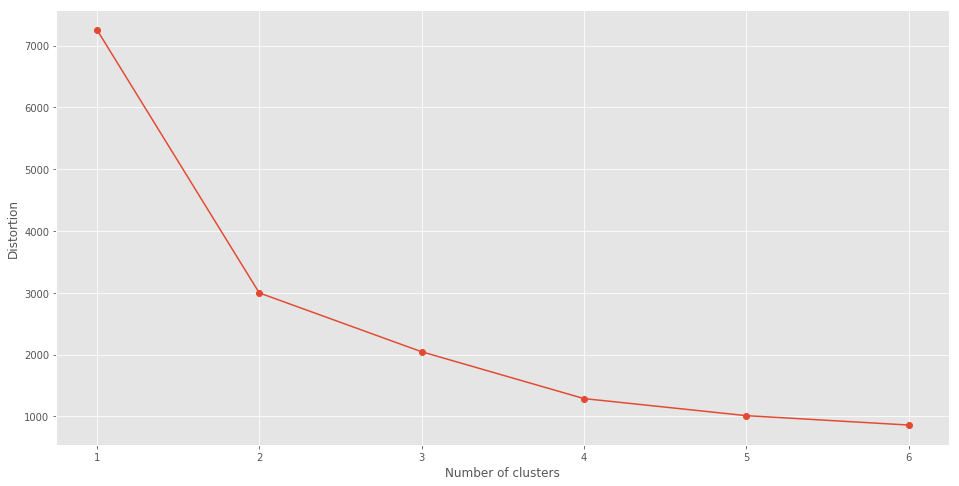

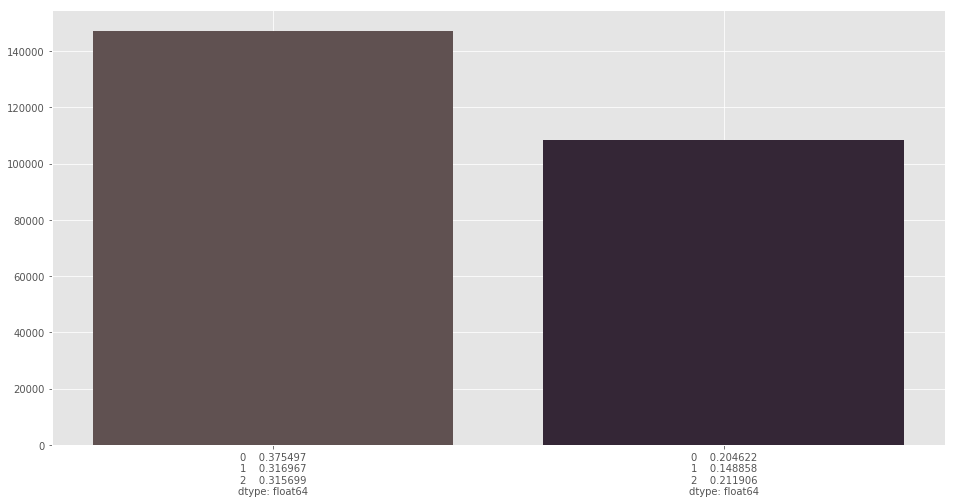

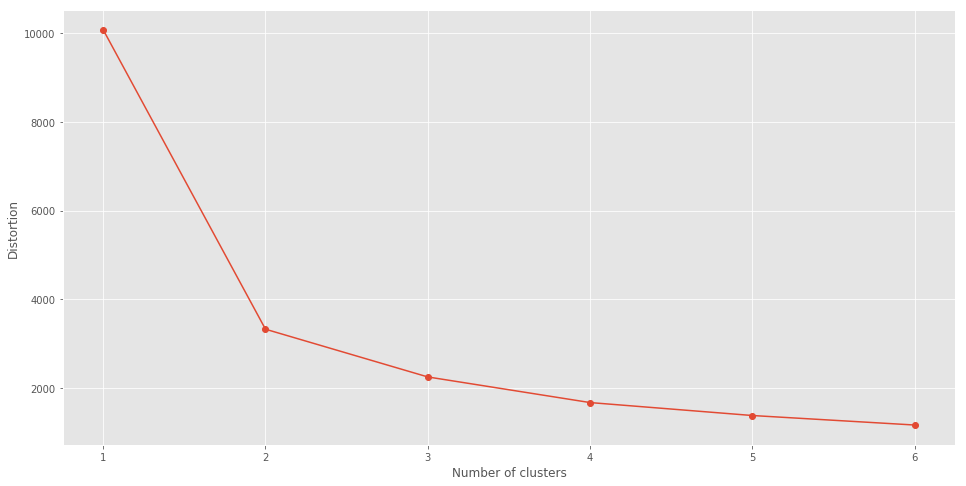

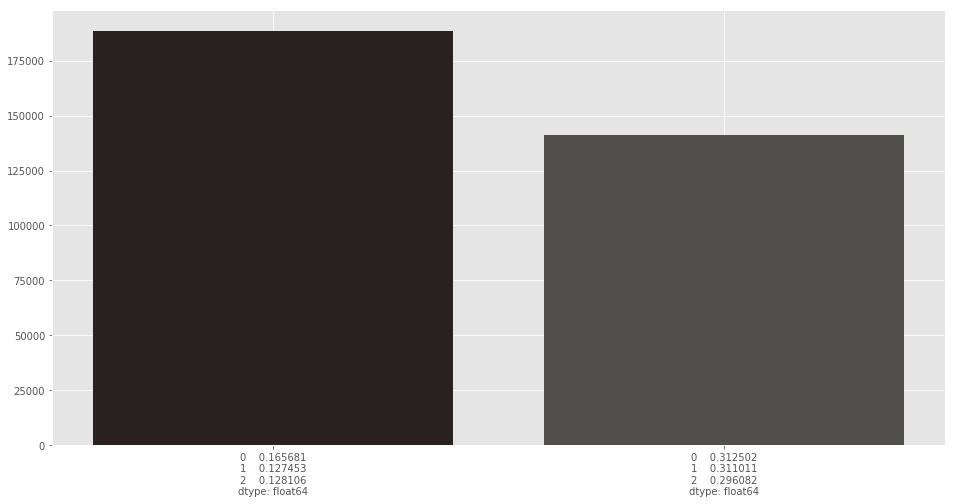

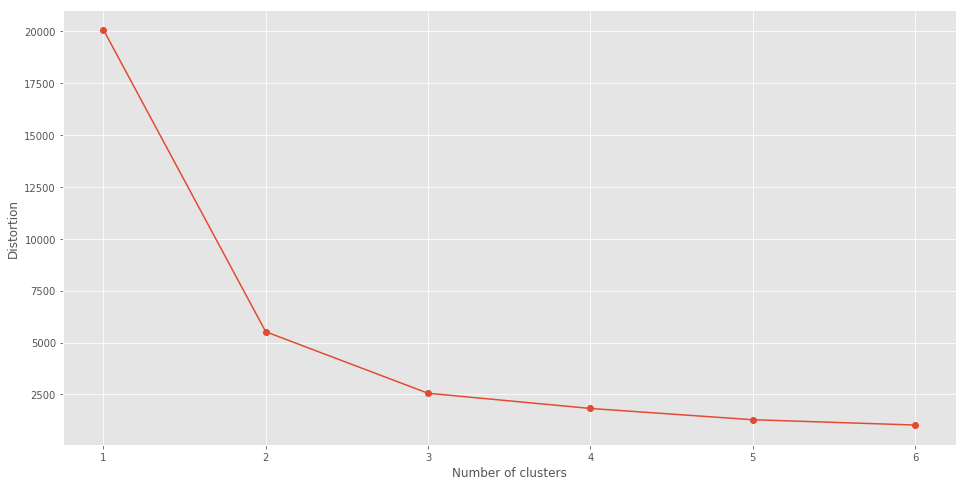

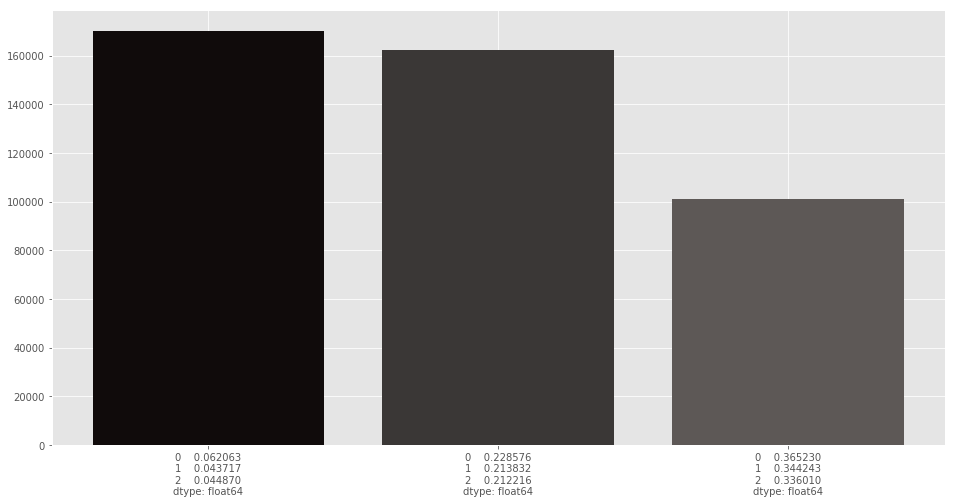

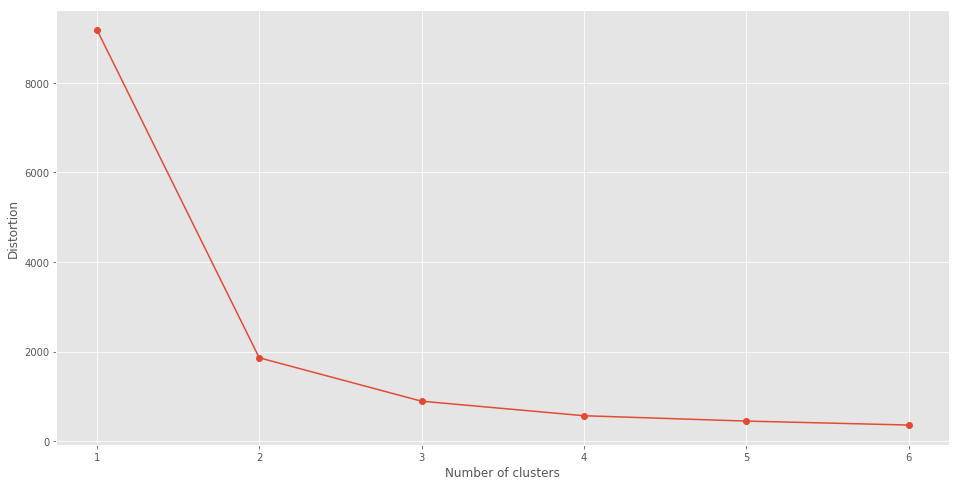

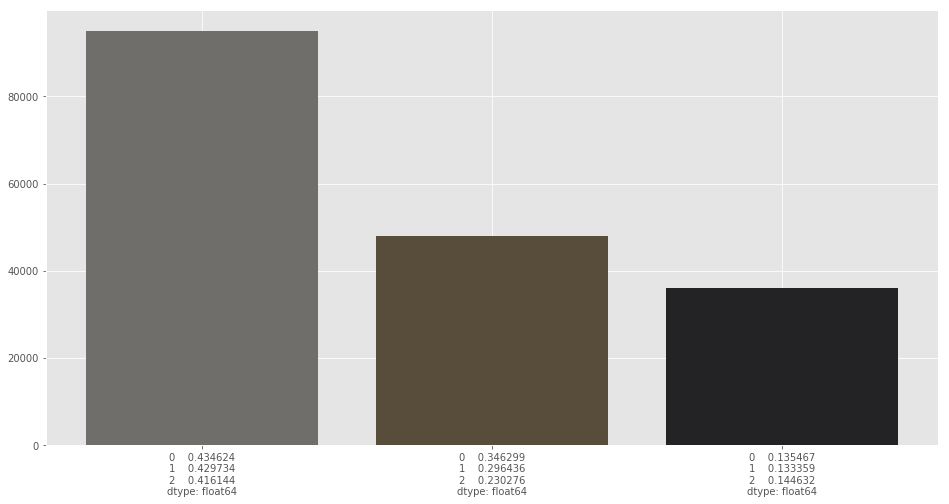

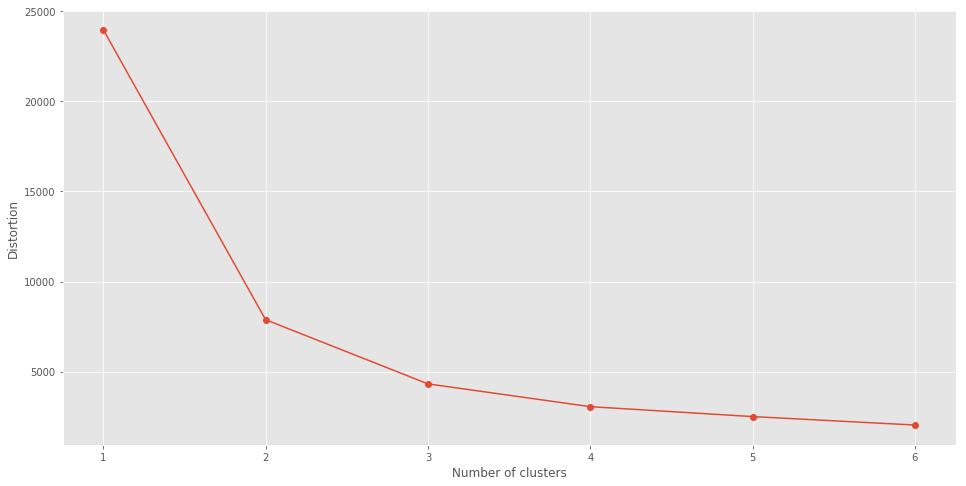

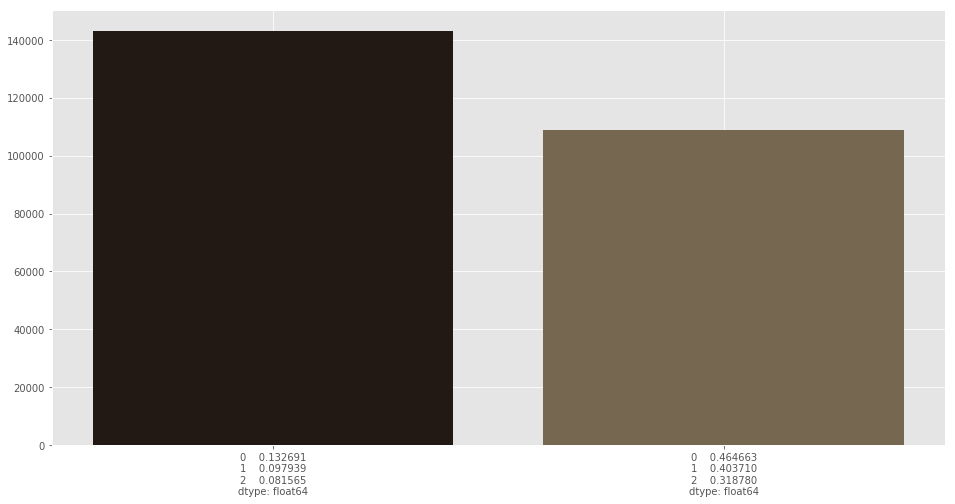

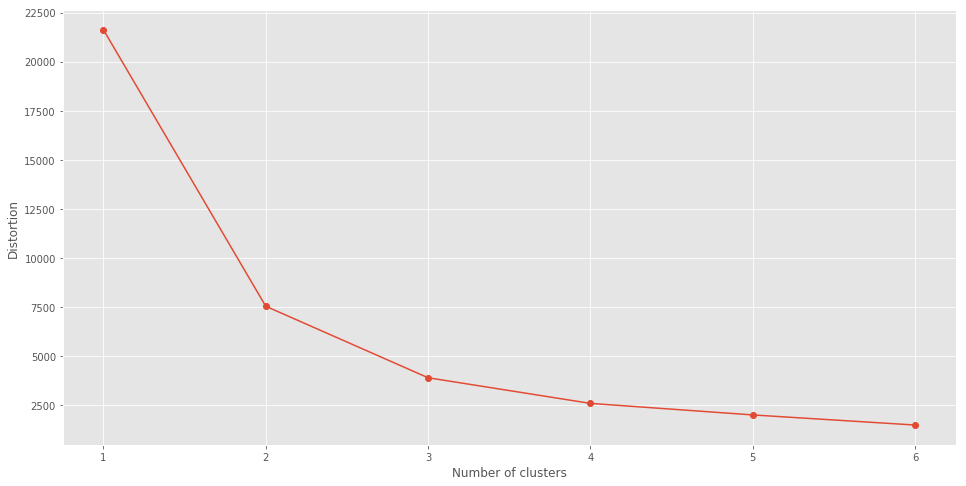

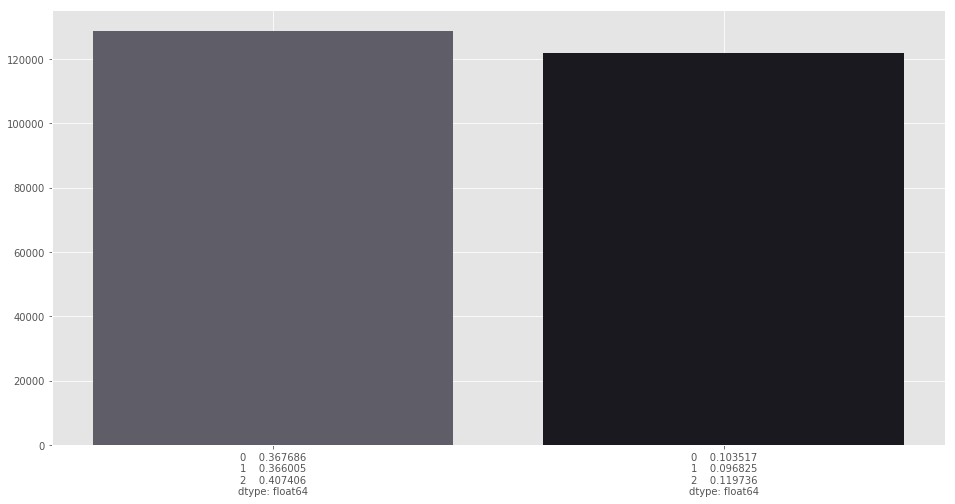

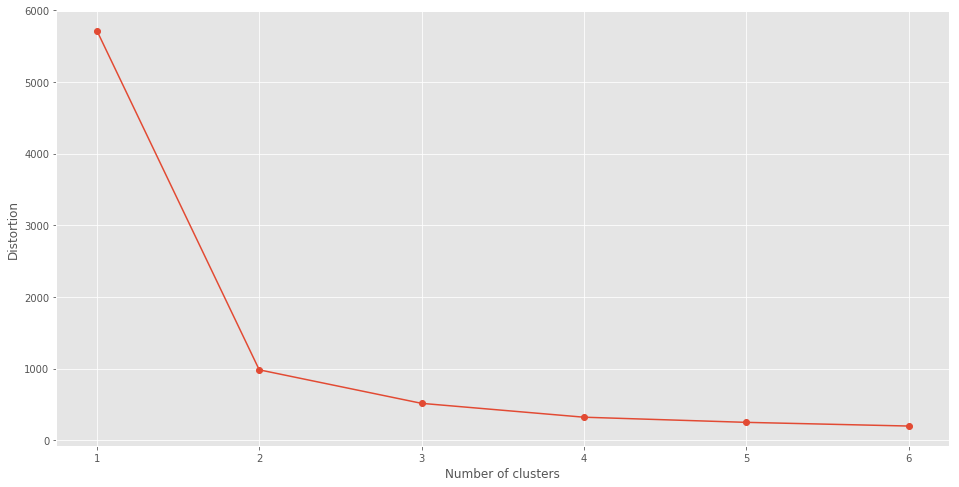

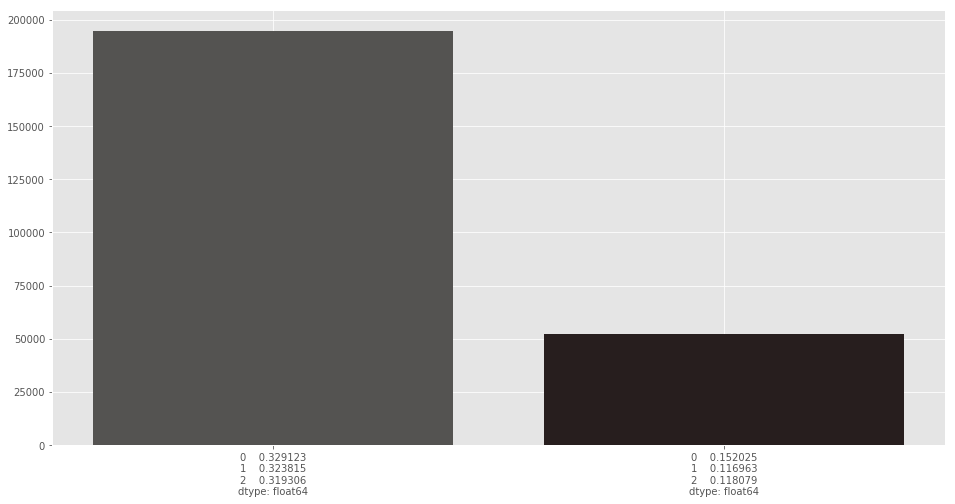

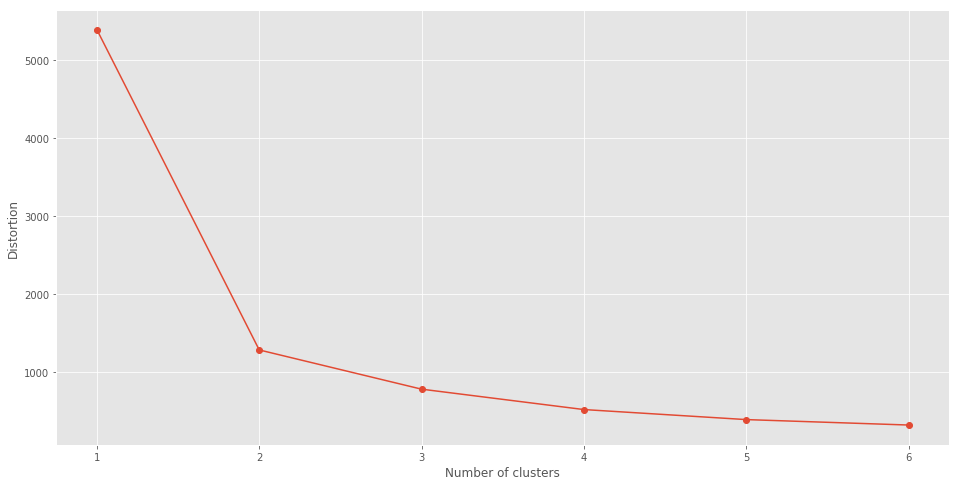

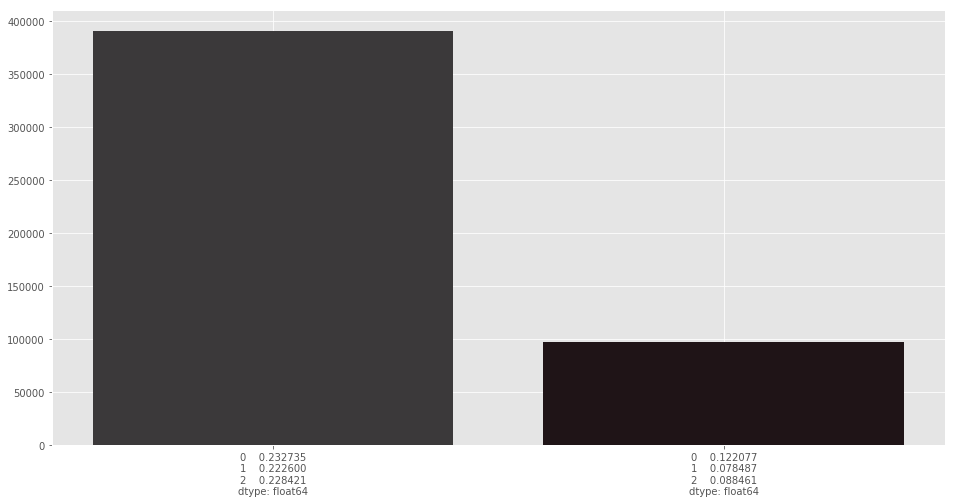

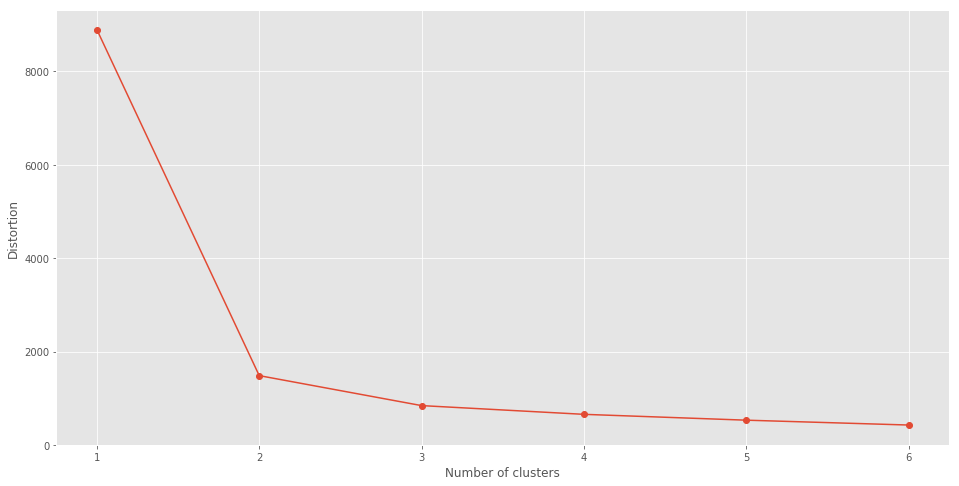

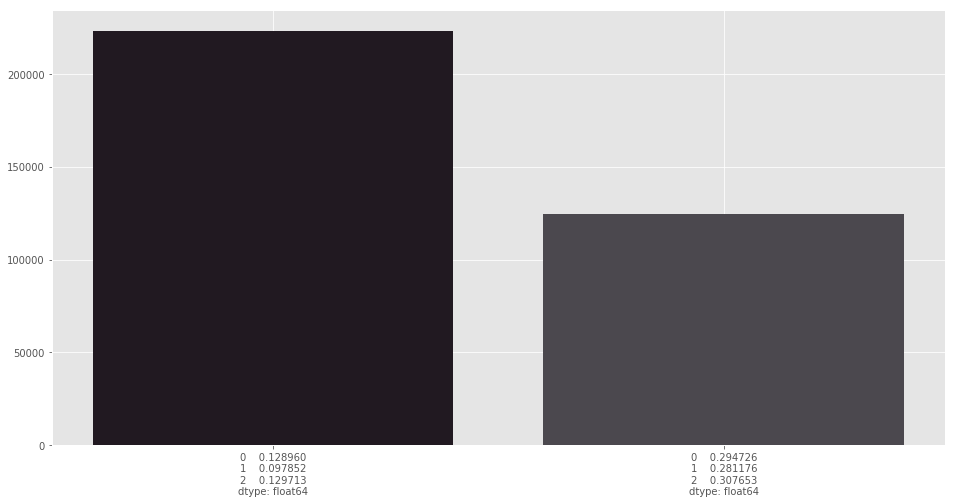

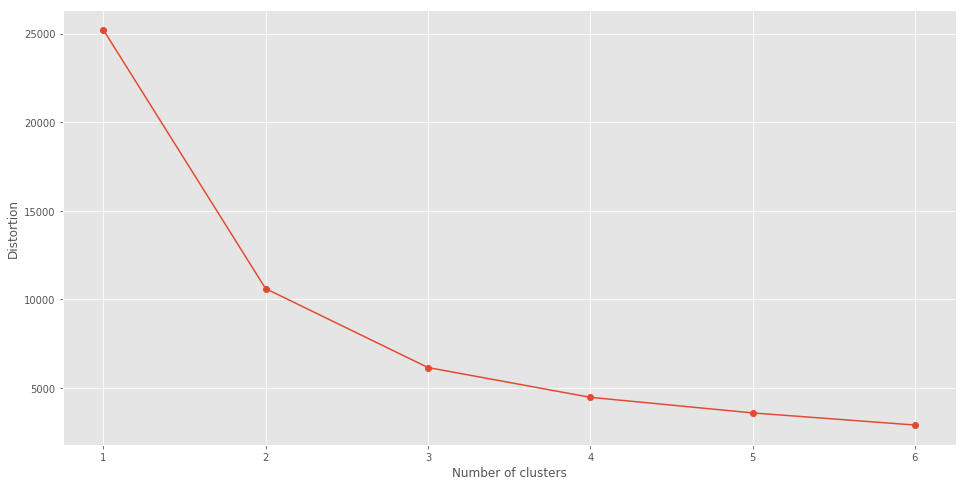

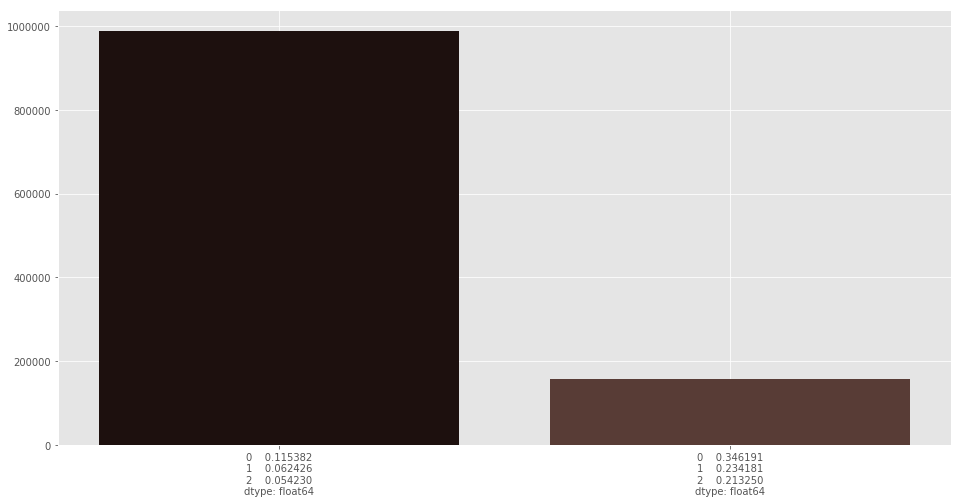

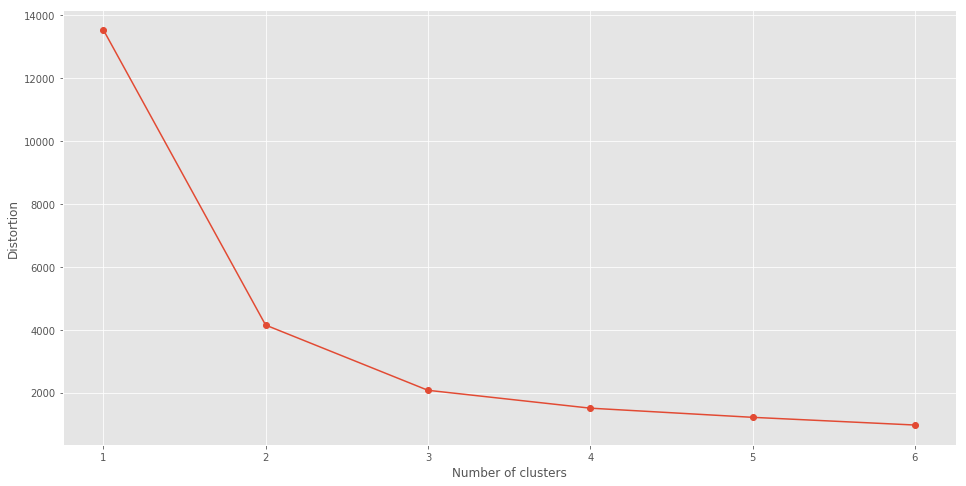

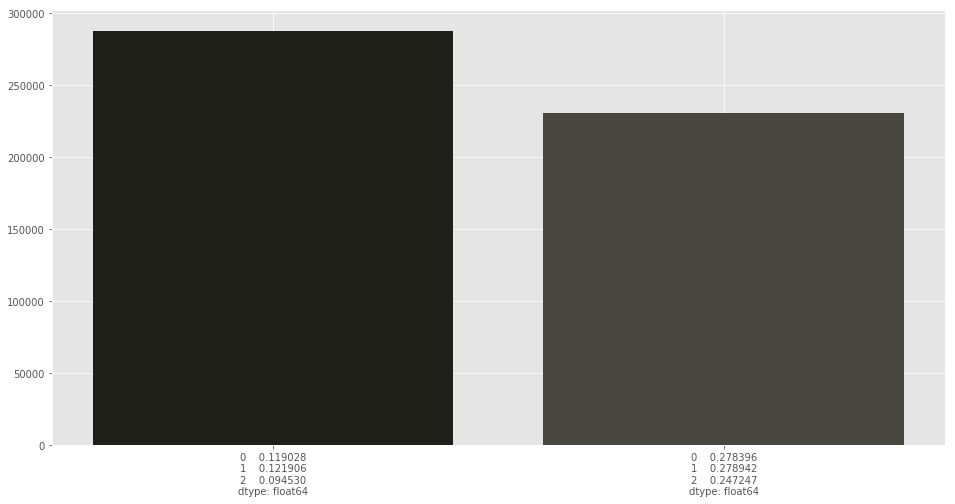

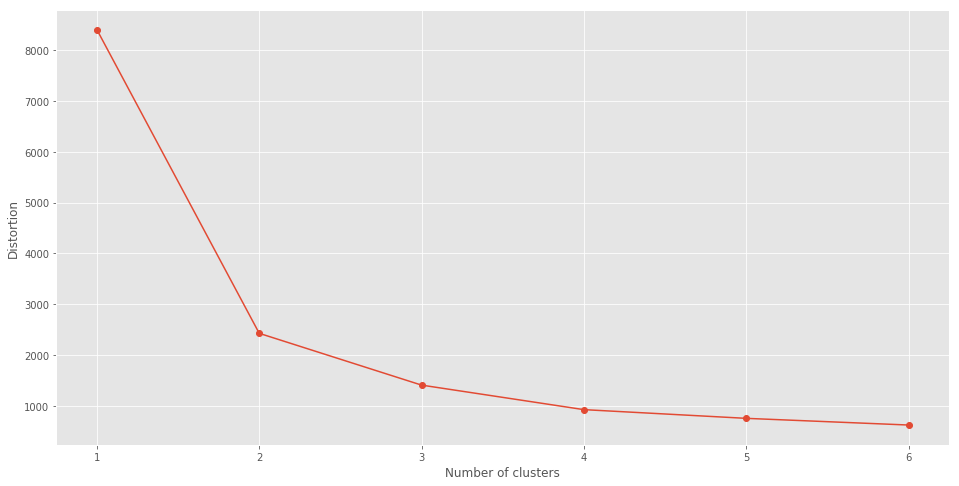

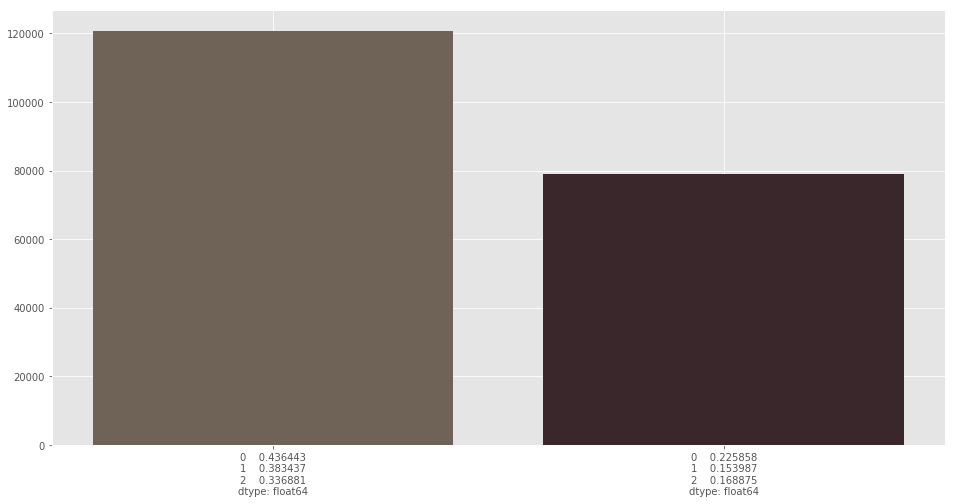

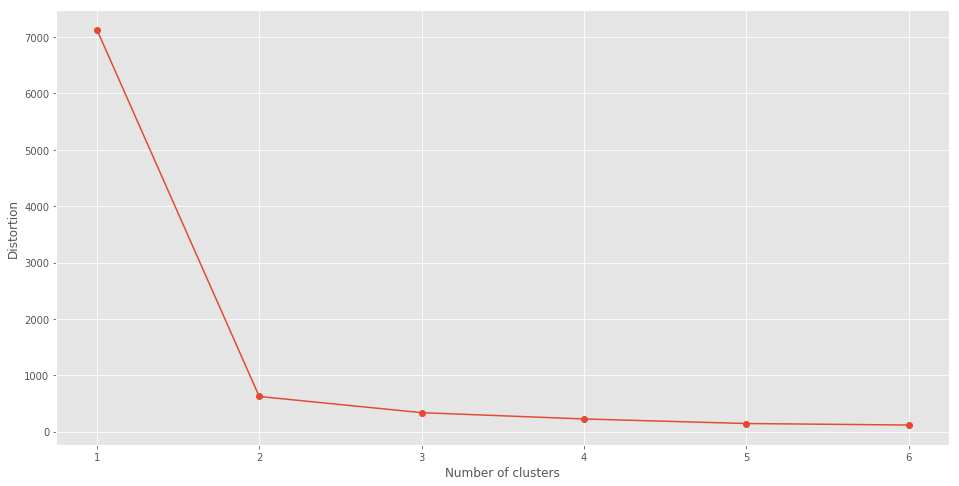

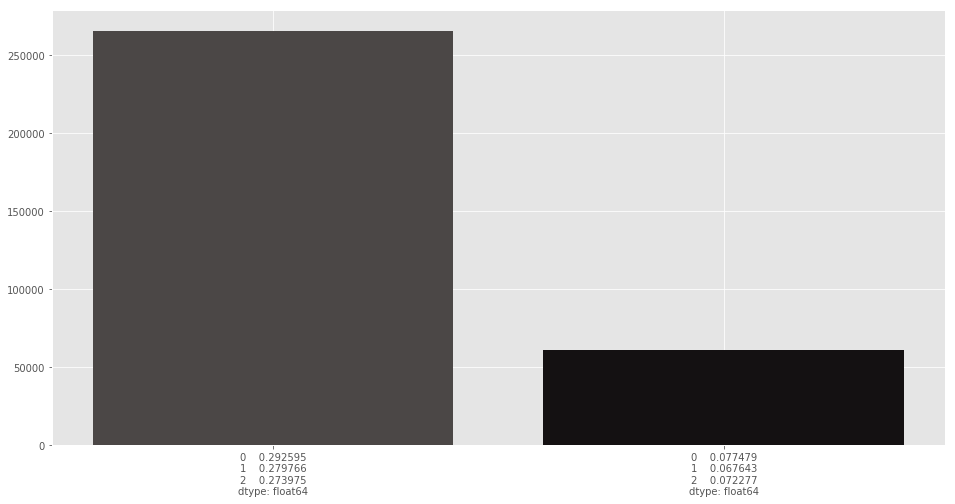

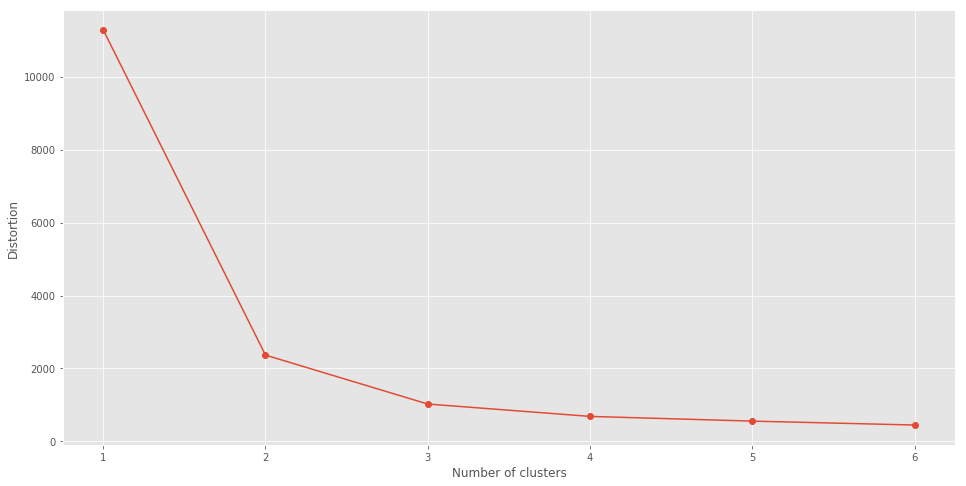

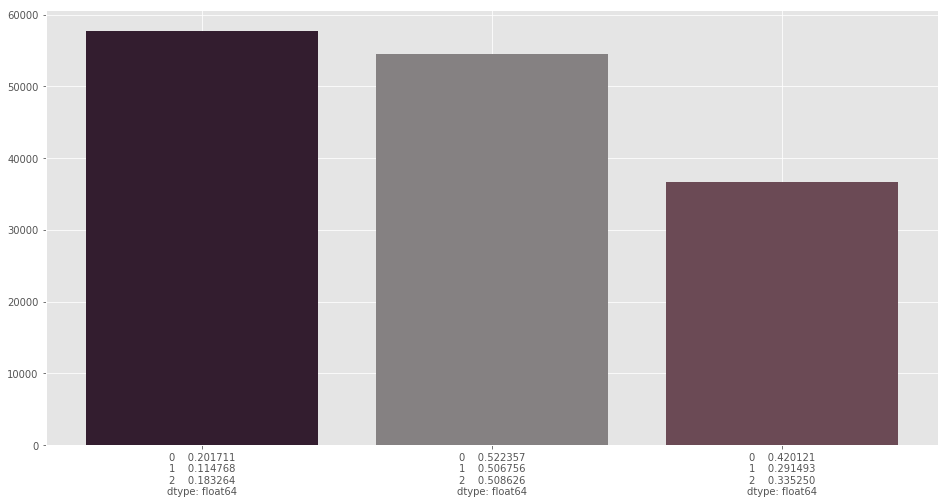

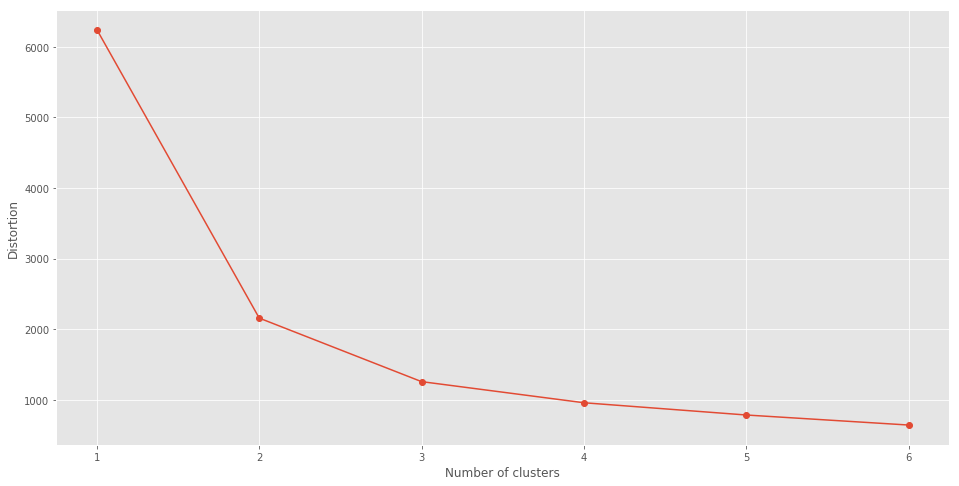

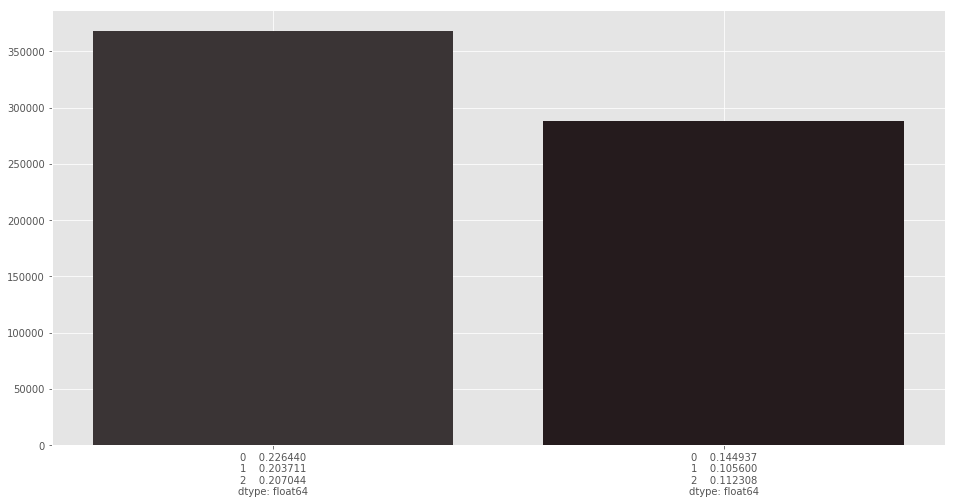

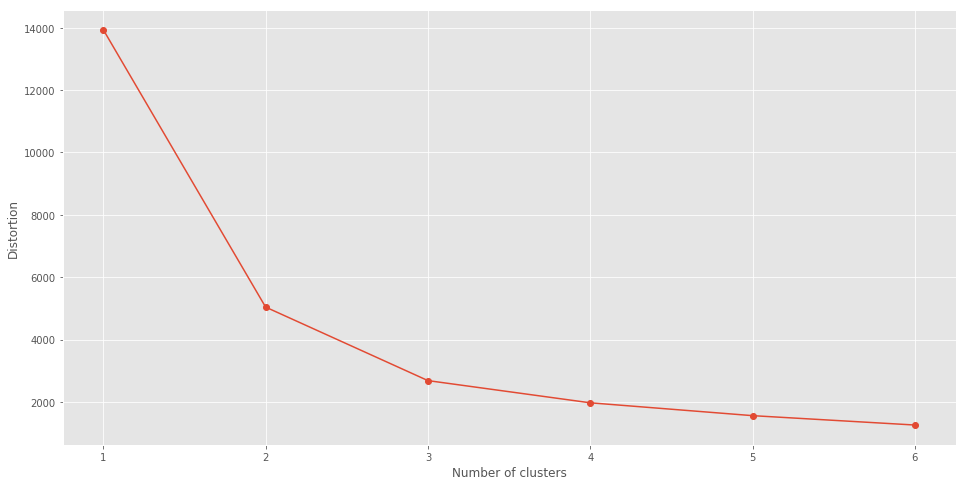

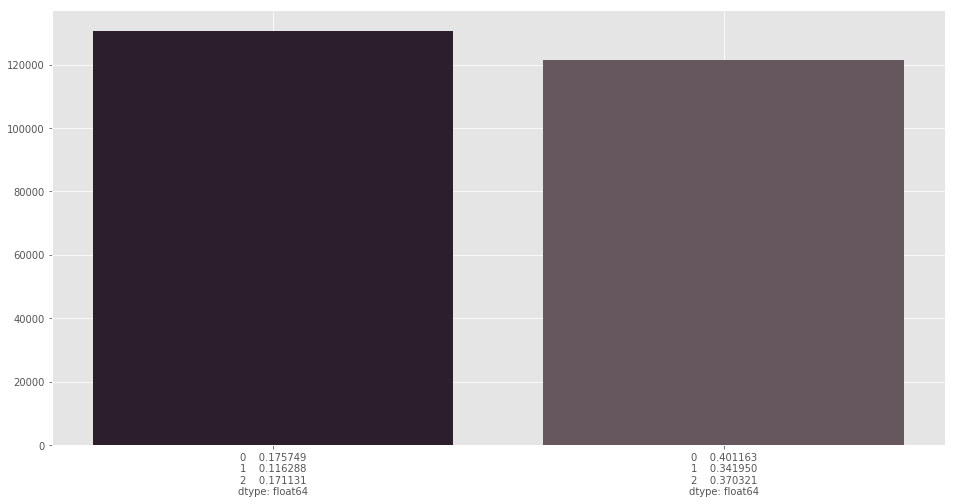

In [38]:
root_path = "../data/download_image_monthly/"
flag = False

for date_path in os.listdir(root_path):
    if date_path == ".DS_Store":
        continue
    date = os.path.join(root_path, date_path)
    save_path = root_path + "result/"
    if os.path.isdir(save_path) == False:
        os.makedirs(save_path)
    date = date + "/full/"
    
    for img_path in tqdm(os.listdir(date)):
        if date_path == ".DS_Store":
            continue
        MAX_CLST = 6
        dist = []
        color_list = []
        
        i_path = os.path.join(date, img_path)
        img = cv2.imread(i_path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        norm_img = preprocess(img_rgb)
        
        img_df = pd.DataFrame(norm_img.reshape(-1,3))
        rgb_array = norm_img.reshape(-1,3)
        
        # elbow method
        decide_clusters(rgb_array)
        
        data_path = os.path.join(save_path, img_path[:8])
        plot_RSS(dist, data_path)
        
        # clustering
        k = k_optimize(dist)
        predict = KMeans(n_clusters=k)
        img_df["cluster_id"] = predict.fit_predict(rgb_array)
        
        for i in range(k):
            rgb_mean = img_df[img_df["cluster_id"] == i].mean()
            color_list.append(rgb_mean[0:3])

        x = np.arange(1,k+1)
        plt.figure(figsize=(16,8))
        plt.bar(x, img_df["cluster_id"].value_counts(), color=color_list, tick_label=color_list, align="center")
        plt.savefig("{}_clustering.png".format(data_path))

        if flag == False:
            rgb_df = pd.DataFrame(np.array(color_list).flatten(), columns=["{}".format(img_path[:8])])
            flag = True
        else:
            concat_df = pd.DataFrame(np.array(color_list).flatten(), columns=["{}".format(img_path[:8])])
            rgb_df = pd.concat([rgb_df, concat_df], axis=1)
            
rgb_df.to_csv("../data/cluster_rgb.csv")

### 前処理

In [18]:
def preprocess(img_rgb):
    n = 2
    img_rgb = cv2.resize(img_rgb, (img.shape[1]//n, img.shape[0]//n))
    # normalize
    img_rgb_norm = img_rgb / np.linalg.norm(img_rgb) * 255
    return img_rgb_norm

### K-mean法に最適なクラスタ数を計算させる関数

In [19]:
import matplotlib.ticker as ticker

In [36]:
def decide_clusters(rgb_array):
    for i in range(1, MAX_CLST+1):
        predict = KMeans(n_clusters=i,
                        init="k-means++",
                        n_init=MAX_CLST,
                        max_iter=300,
                        random_state=98)
        predict.fit(rgb_array)
        dist.append(predict.inertia_)
        
def plot_RSS(dist, img_path):
    plt.figure(figsize=(16,8))
    plt.gca().get_xaxis().set_major_locator(ticker.MaxNLocator(integer=True))
    plt.xlabel('Number of clusters')
    plt.ylabel('Distortion')
    plt.plot(range(1,MAX_CLST+1),dist[:],marker='o')
    plt.savefig("{}_elbow.png".format(img_path))
    
def k_optimize(dist):
    diff = np.array(dist[:-1]) - np.array(dist[1:])
    for i, param in enumerate(dist[1:]):
        if param > diff[i]:
            return i+1